In [1]:
import meep as mp
import numpy as np
from meep import mpb
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from scipy.optimize import root_scalar

from phodex.modes.mpb import gather_ms_results, plot_bands

mp.verbosity.mpb = 0

Using MPI version 4.0, 1 processes


/scratch/local/yaugenst/conda/envs/google/lib/python3.11/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/scratch/local/yaugenst/conda/envs/google/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/scratch/local/yaugenst/conda/envs/google/lib/python3.11/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/scratch/local/yaugenst/conda/envs/google/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


## Modes of a silicon buried oxide waveguide

In [16]:
resolution = 50
lcen = 1.55
fcen = 1 / lcen
wvg_width = 0.45
wvg_height = 0.22
n_core = 3.4777  # Si @ 1550nm
n_clad = 1.4440
num_bands = 4
sy = 3
sz = 2
num_k = 50
k_min = 0.1
k_max = 2.5

k_points = mp.interpolate(num_k, [mp.Vector3(k_min), mp.Vector3(k_max)])
ks = np.array([k.x for k in k_points])

In [17]:
geometry = [
    mp.Block(
        size=mp.Vector3(mp.inf, wvg_width, wvg_height),
        material=mp.Medium(index=n_core),
        center=mp.Vector3(),
    ),
]

geometry_lattice = mp.Lattice(size=mp.Vector3(0, sy, sz))

ms = mpb.ModeSolver(
    geometry_lattice=geometry_lattice,
    geometry=geometry,
    resolution=resolution,
    k_points=k_points,
    num_bands=num_bands,
    default_material=mp.Medium(index=n_clad),
)

In [18]:
results = {}
ms.run_te()
results["te"] = gather_ms_results(ms, 1)
ms.run_tm()
results["tm"] = gather_ms_results(ms, 1)

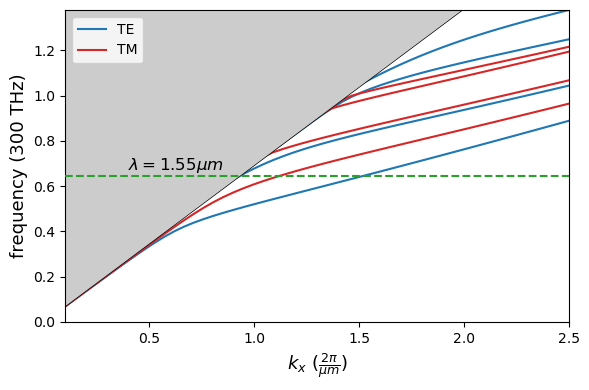

In [19]:
plt.close("all")
fig, ax = plt.subplots(1, 1, figsize=(6, 4), tight_layout=True)
plot_bands(
    {"TE": results["te"]["freqs"], "TM": results["tm"]["freqs"]},
    lcen,
    ks,
    n_clad,
    ax=ax,
)
plt.show()

## Optimization of the waveguide for 1310nm

In [20]:
lcen = 1.31
fcen = 1 / lcen
n_core = 3.4975  # Si @ 1310nm
num_bands = 3


def objective(w):
    geometry = [
        mp.Block(
            size=mp.Vector3(mp.inf, w, wvg_height),
            material=mp.Medium(index=n_core),
            center=mp.Vector3(),
        ),
    ]

    ms = mpb.ModeSolver(
        geometry_lattice=geometry_lattice,
        geometry=geometry,
        resolution=resolution,
        k_points=k_points,
        num_bands=num_bands,
        default_material=mp.Medium(index=n_clad),
    )

    ms.run_te()
    freqs = ms.all_freqs

    # fit the first-order mode
    mode = UnivariateSpline(ks, freqs[:, 1], s=0)

    # find where the mode hits lcen
    cross = root_scalar(
        lambda x: mode(x) - fcen, method="brentq", bracket=[ks[0], ks[-1]]
    ).root

    # and check whether that is above or below the light line
    # positive means below, i.e. propagating
    light_line = UnivariateSpline(ks, ks / n_clad, s=0)
    return light_line(cross) - fcen

In [21]:
w = 0.45
while True:
    w -= 0.01
    if (val := objective(w)) < 0:
        print(f"width = {w}, objective = {val}")
        break
    print(f"width = {w}, objective = {val}")

width = 0.44, objective = 0.08344367560644383
width = 0.43, objective = 0.0704752643668215
width = 0.42, objective = 0.059449989963166305
width = 0.41, objective = 0.04742044560805203
width = 0.39999999999999997, objective = 0.03785069457911705
width = 0.38999999999999996, objective = 0.03003588379229305
width = 0.37999999999999995, objective = 0.02341956908253684
width = 0.36999999999999994, objective = 0.016395075116581448
width = 0.35999999999999993, objective = 0.010809068626282947
width = 0.3499999999999999, objective = 0.006127209592185157
width = 0.3399999999999999, objective = 0.0017463068540775062
width = 0.3299999999999999, objective = -0.00282394011211895


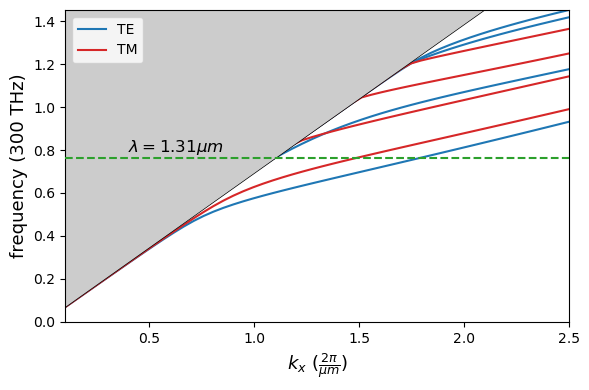

In [22]:
geometry = [
    mp.Block(
        size=mp.Vector3(mp.inf, w, wvg_height),
        material=mp.Medium(index=n_core),
        center=mp.Vector3(),
    ),
]

ms = mpb.ModeSolver(
    geometry_lattice=geometry_lattice,
    geometry=geometry,
    resolution=resolution/2,
    k_points=k_points,
    num_bands=4,
    default_material=mp.Medium(index=n_clad),
)

results = {}
ms.run_te()
results["te"] = gather_ms_results(ms, 1)
ms.run_tm()
results["tm"] = gather_ms_results(ms, 1)

plt.close("all")
fig, ax = plt.subplots(1, 1, figsize=(6, 4), tight_layout=True)
plot_bands(
    {"TE": results["te"]["freqs"], "TM": results["tm"]["freqs"]},
    lcen,
    ks,
    n_clad,
    ax=ax,
)
plt.show()

## Optimization of a silicon nitride waveguide for 1550nm

In [23]:
lcen = 1.55
fcen = 1 / lcen
wvg_height = 0.4
n_core = 1.9963  # Si3N4 @ 1550nm
num_bands = 3


def objective(w):
    geometry = [
        mp.Block(
            size=mp.Vector3(mp.inf, w, wvg_height),
            material=mp.Medium(index=n_core),
            center=mp.Vector3(),
        ),
    ]

    ms = mpb.ModeSolver(
        geometry_lattice=geometry_lattice,
        geometry=geometry,
        resolution=resolution,
        k_points=k_points,
        num_bands=num_bands,
        default_material=mp.Medium(index=n_clad),
    )

    ms.run_te()
    freqs = ms.all_freqs

    # fit the first-order mode so we have a function
    mode = UnivariateSpline(ks, freqs[:, 1], s=0)

    # find where the mode hits lcen
    cross = root_scalar(
        lambda x: mode(x) - fcen, method="brentq", bracket=[ks[0], ks[-1]]
    ).root

    # and check whether that is above or below the light line
    light_line = UnivariateSpline(ks, ks / n_clad, s=0)
    return light_line(cross) - fcen

In [28]:
w = 1.3
while True:
    w -= 0.01
    if (val := objective(w)) < 0:
        print(f"width = {w}, objective = {val}")
        break
    print(f"width = {w}, objective = {val}")

width = 1.29, objective = 0.018531541600647294
width = 1.28, objective = 0.017466406022757175
width = 1.27, objective = 0.016430307182702886
width = 1.26, objective = 0.01541947007526101
width = 1.25, objective = 0.014308640924978744
width = 1.24, objective = 0.013205614133568577
width = 1.23, objective = 0.012185582289838348
width = 1.22, objective = 0.011165668964377429
width = 1.21, objective = 0.01005121309473267
width = 1.2, objective = 0.008972497533404789
width = 1.19, objective = 0.007925482743554757
width = 1.18, objective = 0.006906178349456504
width = 1.17, objective = 0.005798825722448164
width = 1.16, objective = 0.004726746370382839
width = 1.15, objective = 0.0036868398667639912
width = 1.14, objective = 0.002675033643764535
width = 1.13, objective = 0.0015827117656124212
width = 1.1199999999999999, objective = 0.0005140496158545504
width = 1.1099999999999999, objective = -0.000493507817125205


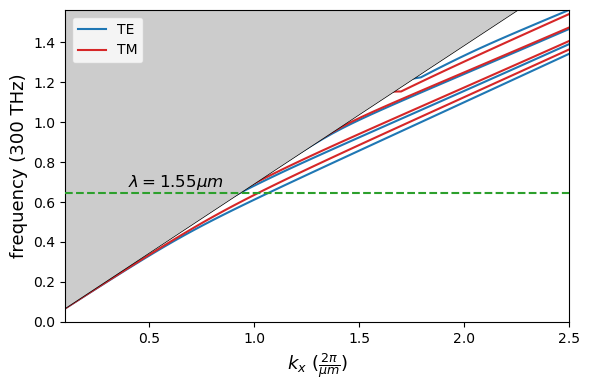

In [29]:
geometry = [
    mp.Block(
        size=mp.Vector3(mp.inf, w, wvg_height),
        material=mp.Medium(index=n_core),
        center=mp.Vector3(),
    ),
]

ms = mpb.ModeSolver(
    geometry_lattice=geometry_lattice,
    geometry=geometry,
    resolution=resolution/2,
    k_points=k_points,
    num_bands=4,
    default_material=mp.Medium(index=n_clad),
)

results = {}
ms.run_te()
results["te"] = gather_ms_results(ms, 1)
ms.run_tm()
results["tm"] = gather_ms_results(ms, 1)

plt.close("all")
fig, ax = plt.subplots(1, 1, figsize=(6, 4), tight_layout=True)
plot_bands(
    {"TE": results["te"]["freqs"], "TM": results["tm"]["freqs"]},
    lcen,
    ks,
    n_clad,
    ax=ax,
)
plt.show()